In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('bhw_ais_ship_2024.csv.gz')
df.head()


,mmsi,imo,name,type,length,width,yday
0,413000000,NaN,NaN,70.0,0.0,0.0,1
1,412000000,NaN,0,NaN,NaN,NaN,1
2,414352330,NaN,NaN,31.0,0.0,0.0,1
3,413355510,0.0,HUA TAI 21,70.0,149.0,21.0,1
4,897898896,NaN,XIPU NAVIGATION,NaN,NaN,NaN,1


In [3]:
dfs=df.drop_duplicates()

In [4]:
dfs=dfs.sort_values(by=['mmsi'])

In [5]:
def pick_type(series):
    s=pd.to_numeric(series, errors='coerce').dropna()
    if s.empty:
        return np.nan
    #首选合法值
    valid_small=s[(s>0)&(s<=100)]
    if not valid_small.empty:
        counts=valid_small.value_counts()
        modes=counts[counts==counts.max()].index
        return int(modes.min())
    positive=s[s>100]
    #大于100的取最小值（实际上异常值）
    if not positive.empty:
        counts=positive.value_counts()
        modes=counts[counts==counts.max()].index
        return int(modes.min())
    return np.nan

def pick_length(series):
    s=pd.to_numeric(series,errors='coerce')
    positive=s[s>0]
    if not positive.empty:
        return positive.min()
    return np.nan

unique_ship_info=dfs.groupby('mmsi').agg({
    'type':lambda x: pick_type(x),
    'length':lambda x: pick_length(x),
}).reset_index()

In [ ]:
unique_ship_info.to_csv('unique_ship_list.csv', index=False)

In [7]:
#清洗处理list\bhw_total_ais_2024.csv.gz
df=pd.read_csv('bhw_total_ais_2024.csv.gz')
df.head()

,time,mmsi,status,lon,lat,sog,cog,trueHeading
0,2024-01-01T01:00:01Z,414479000,0.0,121.9390,37.9717,90,1248,124
1,2024-01-01T01:00:02Z,413299580,0.0,121.9729,37.7481,90,2900,291
2,2024-01-01T01:00:04Z,414470000,0.0,122.0673,37.6930,120,1079,106
3,2024-01-01T01:00:04Z,414049000,0.0,121.9326,37.7206,105,1070,107
4,2024-01-01T01:00:04Z,414822000,0.0,121.9869,37.7087,103,1075,108


In [8]:
df.drop(columns=['status','sog','cog','trueHeading'], inplace=True)

In [9]:
df.drop_duplicates(inplace=True)    

In [11]:
df=df.merge(unique_ship_info, on='mmsi', how='left')

In [13]:
df['time']=pd.to_datetime(df['time'], errors='coerce')

In [14]:
df.sort_values(by=['mmsi','time'], inplace=True)

In [15]:
df.to_csv('cleaned_ais.csv', index=False)

In [9]:
df=pd.read_csv('cleaned_ais.csv')


In [11]:
print(df['type'].isna().sum())
print(df['length'].isna().sum())
print(df['length'].min(), df['length'].max())

835801
1203888
1.0 1022.0


In [12]:
df['type']=pd.to_numeric(df['type'], errors='coerce').fillna(-1).astype(int)
df['length']=pd.to_numeric(df['length'], errors='coerce').fillna(-1.0).astype(float)

In [13]:
print(df['type'].unique())

[ 30  37  55  -1  62  80  31  52  12  89  70  10  79  84  71  73  75  74
  60  56  40  35  72  20  87  83  82  90  50 220   2  69  81  96   1  64
  32  21  78  88 207  76   9  77 245  42  98  53  51  38  26  33  91  86
 251 124 120  11 231   4  18   5 184 255  36  54  99   3   8 146  17  13
  28 250 105  14  85  34  59 253 190 247 191  44  57  95  16  65  19 254
   6  24 128 238  47 192  68 108 223 169 127 111 165 183  39 126 239  41
 123  48 211 244]


In [14]:
df.loc[df['type']>100, 'type'] = -1

In [15]:
df.to_csv('cleaned_ais.csv', index=False)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
#中文字体设置
rcParams['font.sans-serif']=['SimHei']
rcParams['axes.unicode_minus']=False


In [17]:
ship_types = {
    '货船': [70,71,72,73,74,75,76,77,78,79],
    '油船': [80,81,82,83,84,85,86,87,88,89],
    '客船': [60,61,62,63,64,65,66,67,68,69],
    '渔船': [30],
    '危险品船': [71,72,73,74,81,82,83,84,91,92,93,94]
}
# 优先级：危险品优先
priority = ['危险品船','货船','油船','客船','渔船']
ship_sets = {k: set(v) for k,v in ship_types.items()}

def classify_ship_type(code):
    if pd.isna(code):
        return '未知'
    c=int(code)
    if c > 100:
        return '未知'    
    if c == 0:
        return '未知'
    for label in priority:
        if c in ship_sets.get(label, set()):
            return label
    return '非运输船'

def classify_length(val):
    if pd.isna(val):
        return '未知'
    try:
        v = float(val)
    except Exception:
        return '未知'
    if 0 <= v <= 100:
        return "100米及以下"
    if 101 <= v <= 200:
        return "101~200米"
    if 201 <= v <= 300:
        return "201~300米"
    if 301 <= v <= 370:
        return "301~370米"
    if v >= 371:
        return "371米以上"
    return '未知'

# 应用到单个 DataFrame
df['ship_type'] = df['type'].apply(classify_ship_type)
df['length_category'] = df['length'].apply(classify_length)


C:\Users\85842\AppData\Local\Temp\ipykernel_80040\121866405.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=type_series_plot, order=order, palette='muted')


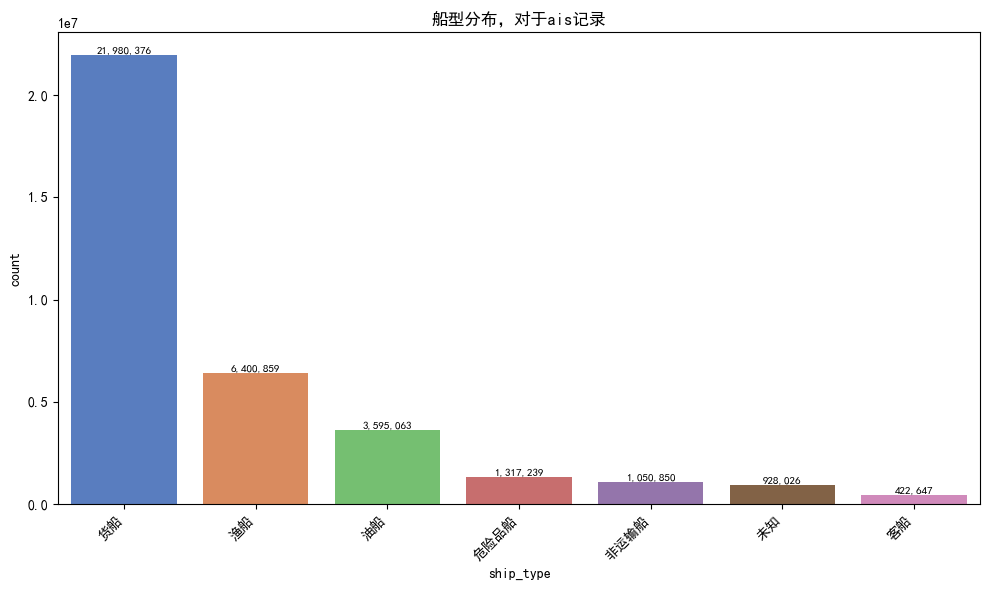

In [18]:
plt.figure(figsize=(10,6))
# NaN
type_series_plot = df['ship_type'].fillna('Nan').astype(str)
order = type_series_plot.value_counts().index
ax = sns.countplot(x=type_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("船型分布，对于ais记录")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()

C:\Users\85842\AppData\Local\Temp\ipykernel_80040\839108044.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x=length_series_plot, order=order, palette='muted')


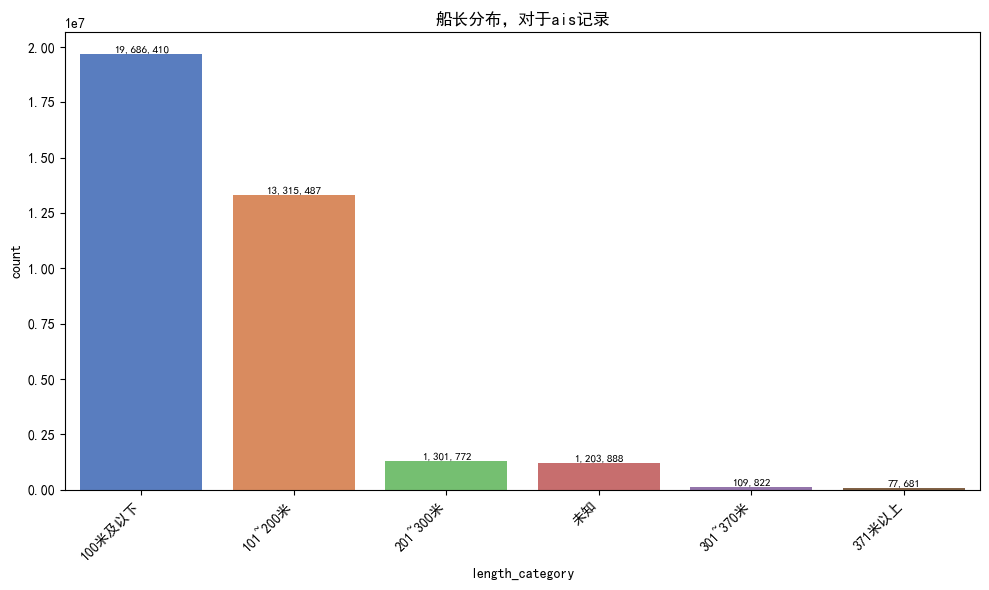

In [19]:
plt.figure(figsize=(10,6))
#长度分类
length_series_plot=df['length_category'].fillna('Nan').astype(str)
order=length_series_plot.value_counts().index
ax=sns.countplot(x=length_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("船长分布，对于ais记录")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()

In [20]:
ship_types = {
    '货船': [70,71,72,73,74,75,76,77,78,79],
    '油船': [80,81,82,83,84,85,86,87,88,89],
    '客船': [60,61,62,63,64,65,66,67,68,69],
    '渔船': [30],
    '危险品船': [71,72,73,74,81,82,83,84,91,92,93,94]
}
# 优先级：危险品优先
priority = ['危险品船','货船','油船','客船','渔船']
ship_sets = {k: set(v) for k,v in ship_types.items()}

def classify_ship_type(code):
    if pd.isna(code):
        return '未知'
    c=int(code)
    if c > 100:
        return '未知'    
    if c == 0:
        return '未知'
    for label in priority:
        if c in ship_sets.get(label, set()):
            return label
    return '非运输船'

def classify_length(val):
    if pd.isna(val):
        return '未知'
    try:
        v = float(val)
    except Exception:
        return '未知'
    if 0 <= v <= 100:
        return "100米及以下"
    if 101 <= v <= 200:
        return "101~200米"
    if 201 <= v <= 300:
        return "201~300米"
    if 301 <= v <= 370:
        return "301~370米"
    if v >= 371:
        return "371米以上"
    return '未知'

# 应用到单个 DataFrame
unique_ship_info['ship_type'] = unique_ship_info['type'].apply(classify_ship_type)
unique_ship_info['length_category'] = unique_ship_info['length'].apply(classify_length)


C:\Users\85842\AppData\Local\Temp\ipykernel_80040\3250544069.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=type_series_plot, order=order, palette='muted')


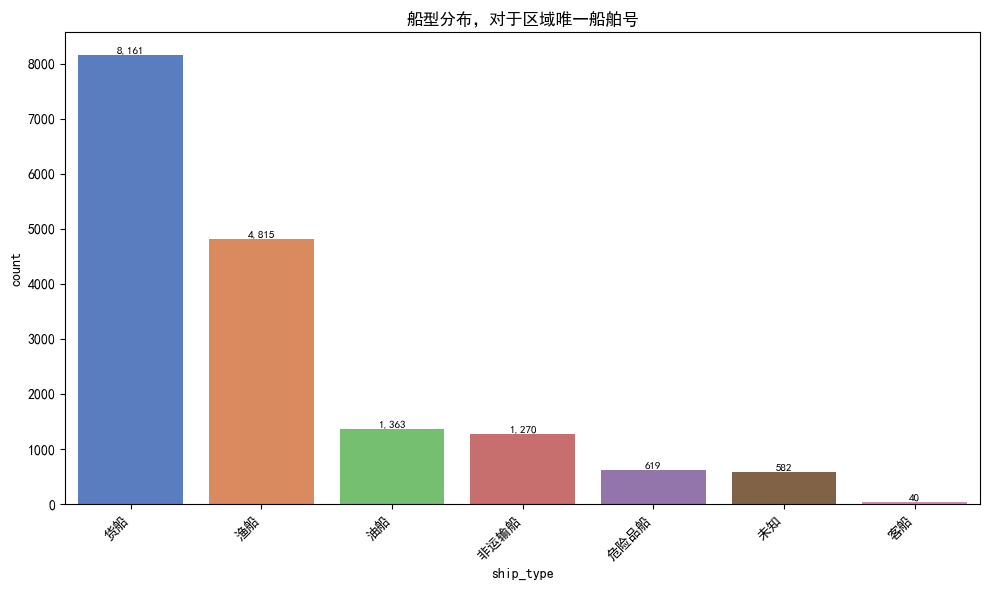

In [22]:
plt.figure(figsize=(10,6))
# NaN
type_series_plot = unique_ship_info['ship_type'].fillna('Nan').astype(str)
order = type_series_plot.value_counts().index
ax = sns.countplot(x=type_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("船型分布，对于区域唯一船舶号")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()

C:\Users\85842\AppData\Local\Temp\ipykernel_80040\1340129175.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x=length_series_plot, order=order, palette='muted')


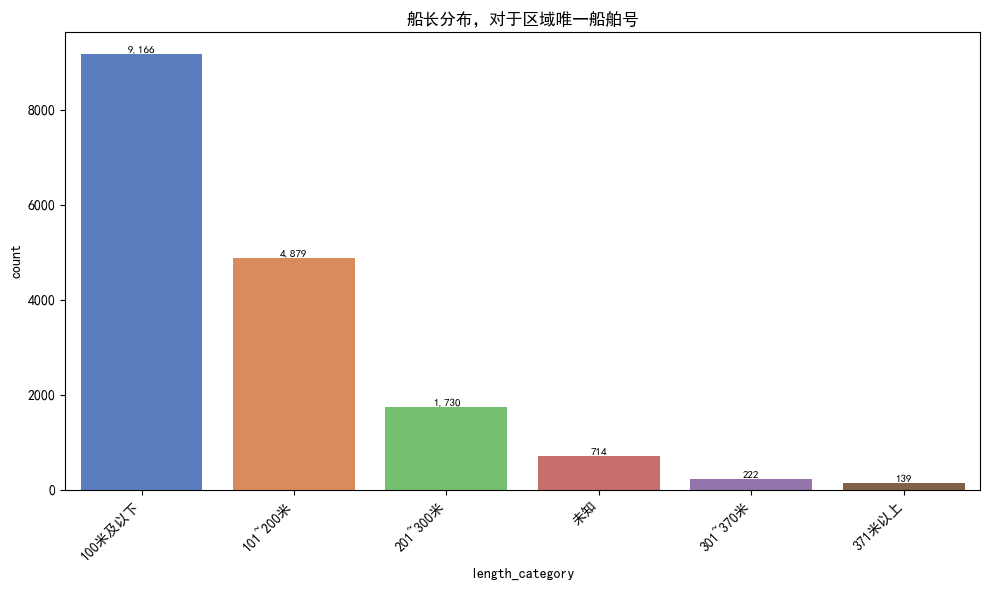

In [23]:
plt.figure(figsize=(10,6))
#长度分类
length_series_plot=unique_ship_info['length_category'].fillna('Nan').astype(str)
order=length_series_plot.value_counts().index
ax=sns.countplot(x=length_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("船长分布，对于区域唯一船舶号")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()

In [3]:
df=pd.read_csv('bhw_ais_ship_2024.csv.gz')

In [ ]:
# 返回所有属于 type 不止一种的 mmsi 的行
df_changed_groups = df.groupby('mmsi').filter(lambda g: g['type'].nunique() > 1)